## Random Pursuit Extrapolation

In [1]:
import numpy as np
import pandas as pd
import allantools
import random

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Noise Removal

There are several ways to remove the noise: Minus Optical Frequency Atomic Clock or by filtering

In [2]:
minus_optical_data_dir = '/opt/beamformer/GAN/data/real_after_30000.csv'
FIR_data_dir = '/opt/beamformer/GAN/data/filtered_data.csv'

df_minus_optical_data_all = pd.read_csv(minus_optical_data_dir, header = None)
df_FIR_data = pd.read_csv(FIR_data_dir, header = None)

print(df_minus_optical_data_all.head(5))
print('---------------------------------------------------------------------------------')
print(df_FIR_data.head(5))

              0             1             2             3             4
0 -4.537900e-14 -1.173813e-13 -4.935266e-14  5.261262e-14  3.341675e-14
1 -2.265000e-14 -1.012483e-13 -2.193466e-14  7.542133e-14  5.472819e-14
2 -2.400067e-14 -1.073680e-13 -3.274267e-14  7.192254e-14  4.664103e-14
3 -3.465033e-14 -1.099903e-13 -3.329933e-14  6.341656e-14  4.328410e-14
4 -4.402800e-14 -1.180173e-13 -4.402800e-14  5.793730e-14  3.468831e-14
---------------------------------------------------------------------------------
              0             1             2             3             4
0 -3.186127e-14 -1.042013e-13 -3.368007e-14  7.139593e-14  4.629043e-14
1 -3.329154e-14 -1.050449e-13 -3.480009e-14  7.011645e-14  4.475857e-14
2 -3.232515e-14 -1.039899e-13 -3.387485e-14  7.111891e-14  4.525628e-14
3 -3.188633e-14 -1.039053e-13 -3.381625e-14  7.073285e-14  4.516182e-14
4 -3.225678e-14 -1.042485e-13 -3.383386e-14  7.039006e-14  4.487599e-14


In [3]:
# NOTE: We only use 3 clocks out of 5
df_minus_optical_data = df_minus_optical_data_all.iloc[:,1:4]

taus - [1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03
 4.0960e+03 8.1920e+03 1.6384e+04]
adevs - [8.62941227e-15 4.80745940e-15 2.81686893e-15 2.30855263e-15
 1.91517625e-15 1.52644771e-15 1.14856427e-15 8.25145040e-16
 6.40353514e-16 4.97971238e-16 4.82286071e-16 5.89988237e-16
 1.03310482e-15 2.04180207e-15 4.11935315e-15]
----------------------------------------
taus - [1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03
 4.0960e+03 8.1920e+03 1.6384e+04]
adevs - [8.56004643e-15 4.65528123e-15 2.52071931e-15 1.92582714e-15
 1.60668913e-15 1.30907023e-15 1.02082863e-15 7.13577087e-16
 5.64153377e-16 4.02652984e-16 3.50001067e-16 3.26666782e-16
 4.55192255e-16 8.39947833e-16 1.56480677e-15]
----------------------------------------
taus - [1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.28

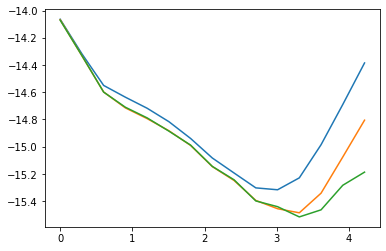

In [4]:
for i in range(df_minus_optical_data.shape[1]):
    (taus, adevs, errors, ns) = allantools.adev(data=df_minus_optical_data.iloc[:,i].to_numpy(), data_type='freq')
    print('taus - %s' % taus)
    print('adevs - %s' % adevs)
    print("----------------------------------------")
    plt.plot(np.log10(taus), np.log10(adevs))
plt.show()

### 2. Learning weight with Inverse Variance

Use traditional inverse variance to learn the weight for each H-maser

In [5]:
def inverse_variance(clock_data:np.ndarray, window_size:int, start_inx:int = 0, tau_level:int = 3):
    # clock_data: array with shape - number_records * number_clock
    # window_size: number of records within the calculation window
    # start_idx: start record index of the window, default is 0
    # tau_level: using allan variance for tau = 2 ** tau_level, default is tau = 8
    inverse_variance = list()

    for k in range(clock_data.shape[1]):
        clock = clock_data[start_inx:start_inx + window_size, k]
        (taus, adevs, errors, ns) = allantools.adev(data=clock, data_type='freq')
        inverse_variance.append(1.0 / (adevs[tau_level + 1] ** 2))

    inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
    return inverse_variance

In [6]:
inverse_variance_start_idx = 0
inverse_variance_window_size = int(60 / 5 * 24) # 24 hours, 1 point every 5 min
clock_arr = df_minus_optical_data.to_numpy()
inverse_variance_weights = inverse_variance(clock_arr, inverse_variance_window_size, inverse_variance_start_idx)
print(inverse_variance_weights)

[0.18309078 0.42019643 0.39671279]


### 3. Sigma calculation

In [7]:
def cal_sigmas(clock_data:np.ndarray, window_size:int, start_inx:int = 0):
    clocks = clock_data[start_inx:start_inx + window_size, :]
    sigmas = np.std(clocks, axis=0)
    return sigmas

In [8]:
sigmas = cal_sigmas(clock_arr, inverse_variance_window_size, inverse_variance_start_idx)
print(sigmas)

[6.99350707e-15 6.61503707e-15 6.78670864e-15]


### 4. Jump generation

In [9]:
rp_start_inx = inverse_variance_start_idx + inverse_variance_window_size
rp_window_size = 12 * 24     # 24 hours, 1 point every 5 min
N = 12 * 6                   # 6 hours, 1 point every 5 min
s_size = 1
#n_pred = clock_arr.shape[0] - (rp_start_inx + rp_window_size) - 1
n_pred = 40000
remaining_size = clock_arr.shape[0] - inverse_variance_window_size

print('**************************** SUMMARY ****************************')
print('Original Data Shape: %s' % str(clock_arr.shape))
print('Inverse Variance Shape: (%s, %s)' % (inverse_variance_window_size, clock_arr.shape[1]))
print('Remaining Data Shape: (%s, %s)' % (remaining_size, clock_arr.shape[1]))
print('Random Pursuit Start Index %s and Window Size: %s' % (rp_start_inx, rp_window_size))
print('Random Pursuit Values to predict: %s' % n_pred)

**************************** SUMMARY ****************************
Original Data Shape: (74271, 3)
Inverse Variance Shape: (288, 3)
Remaining Data Shape: (73983, 3)
Random Pursuit Start Index 288 and Window Size: 288
Random Pursuit Values to predict: 40000


In [10]:
def generate_jump(jump_lower_bound:float, jump_higher_bound:float, clock_remaining_size:int, rand_keep_size:int,
                  sigmas:np.array, jump_clock_idx:list, if_same_idx:bool, if_same_direction:bool):
    """generate random jump.
    # Arguments
        jump_lower_bound: Float, lower bound of jump, number of sigmas.
        jump_higher_bound: Float, upper bound of jump, number of sigmas.
        clock_remaining_size: Integer, size of one clock.
        rand_keep_size: Integer, size of random jumps. Should be less than clock_remaining_size.
        sigmas: Ndarray, with shape (num_clocks, ). sigma for each clock.
        jump_clock_idx: A list, contains the index of jump clocks.
        if_same_idx: Boolean, if the clocks in list jump_clock_idx jumps at the same index.
        if_same_direction: Boolean, if the clocks in list jump_clock_idx jumps in the same direction.

    # Returns
        jumps: Ndarray, with shape (clock_remaining_size, num_clocks), contains the jump value for each clock at each time point.
        jump_idx_list:  Ndarray, with shape (rand_keep_size, 1), contains the index of jumps.
    """
    
    rand_keep_idx_list = list()
    jump_amplifer = np.random.uniform(jump_lower_bound, jump_higher_bound, (clock_remaining_size, 1))
    zeros = np.zeros((clock_remaining_size, sigmas.shape[0]))
    rand_keep_idx = random.sample(range(clock_remaining_size), rand_keep_size)
    neg_idx = random.sample(rand_keep_idx, len(rand_keep_idx) // 2)

    if len(jump_clock_idx) == 1:
        print('1 clock jumps, the index is %s' % jump_clock_idx[0])
        zeros[rand_keep_idx,jump_clock_idx[0]] = jump_amplifer[rand_keep_idx,0] * sigmas[jump_clock_idx[0]]
        zeros[neg_idx,i] = zeros[neg_idx,i] * (-1)
        rand_keep_idx_list.append(rand_keep_idx)
    elif len(jump_clock_idx) == 2:
        if if_same_idx:
            if if_same_direction:
                print('2 clocks jump in same direction, the index are %s' % str(jump_clock_idx))
                for idx in jump_clock_idx:
                    zeros[rand_keep_idx,idx] = jump_amplifer[rand_keep_idx,idx] * sigmas[idx]
                    zeros[neg_idx,idx] = zeros[neg_idx,idx] * (-1)
                    rand_keep_idx_list.append(rand_keep_idx)
            else:
                print('2 clocks jump in different direction, the index are %s' % str(jump_clock_idx))
                switch = 1
                for idx in jump_clock_idx:
                    zeros[rand_keep_idx,idx] = jump_amplifer[rand_keep_idx,idx] * sigmas[idx] * switch
                    zeros[neg_idx,idx] = zeros[neg_idx,idx] * (-1) * switch
                    rand_keep_idx_list.append(rand_keep_idx)
                    switch *= -1
        else:
            raise Exception('Goes back to 1 clock jump scenenario. Exit')
    else:
        raise Exception('Length of jump_clock_idx should be 1 or 2. Exit')

    return zeros, np.array(rand_keep_idx_list).T

In [11]:
jump_lower_bound = 3.0
jump_higher_bound = 5.0
rand_keep_size = 4000
jump_clock_idx = [0]

# Works only when len(jump_clock_idx) == 2
if_same_idx = True
if_same_direction = False

jumps, jump_idx_list = generate_jump(jump_lower_bound, jump_higher_bound, remaining_size-rp_window_size, rand_keep_size, sigmas, jump_clock_idx, if_same_idx, if_same_direction)

1 clock jumps, the index is 0


In [12]:
final_jumps = np.concatenate((np.zeros((rp_window_size, clock_arr.shape[1])), jumps), axis=0)

print('Jumps Data Shape: %s' % str(jumps.shape))
print('By adding Zeros, Final Jumps Data Shape: %s' % str(final_jumps.shape))
print('Random Jump Index Shape: %s' % str(jump_idx_list.shape))
clock_rp_arr = clock_arr[rp_start_inx:,]
clock_rp_arr_with_jumps = clock_rp_arr + final_jumps

Jumps Data Shape: (73695, 3)
By adding Zeros, Final Jumps Data Shape: (73983, 3)
Random Jump Index Shape: (4000, 1)


### 5. Drift learning and Extrapolation with Random Pursuit

Use random pursuit to learn the weight for each H-maser

In [13]:
# Minus H-ensemble first
clock_rp_ensemble = np.dot(clock_rp_arr_with_jumps, inverse_variance_weights)
clock_rp_minus_ensemble = clock_rp_arr_with_jumps - clock_rp_ensemble.reshape(-1,1)
print('After minus ensemble Data, has Shape: %s' % str(clock_rp_minus_ensemble.shape))

After minus ensemble Data, has Shape: (73983, 3)


In [14]:
#for i in range(clock_rp_minus_ensemble.shape[1]):
    #clock_x = clock_rp_minus_ensemble[:,i]
    #clock_y = clock_rp_minus_ensemble[rp_window_size:,i]

In [15]:
import random_pursuit
'''
        data_x: A ndarray, a series x value.
        data_y: A ndarray, corresponding series of y value.
        inx_h: Integer, max index of history data.
        l_inx: Integer, length of history data used for pursuit. Or say, the size of sliding window.
        N: Interger, number of points in each regression.
        inx_p: Integer, the index of the data point to predict. If set to -1, the point with index (inx_h+1) will be predicted.
        n_pred: Interger, number of points to predict with sliding window.
        s_size: Interger, the moving step size of sliding window.
        percent_value: Float, max percentage for weight recaculation.
        method: String, 'inverse' or 'softmax', how weights are calculated from losses
'''

clock_rp_extrapolation_list = list()

for i in [0]:
    print('****************************** Clock %s ******************************' % i)
    clock_x = np.arange(clock_rp_minus_ensemble.shape[0]).reshape(-1,1) * 300  # 1 point every 5 minute
    clock_y = clock_rp_minus_ensemble[:,i]
    inx_h = rp_window_size - 1
    l_inx = rp_window_size
    N = N
    n_pred = n_pred
    s_size = s_size
    method = 'inverse'
    
    clock_pred_results, alert_idxs, refined_clock_y = random_pursuit.random_pursuit(
        data_x = clock_x, 
        data_y = clock_y, 
        threshold = 3 * sigmas[i],
        inx_h = inx_h, 
        l_inx = l_inx, 
        N = N,
        inx_p = -1, 
        n_pred = n_pred, 
        s_size = s_size, 
        percent_value = -1, 
        with_self_resid = False,
        method = method
    )
    clock_rp_extrapolation_list.append(clock_pred_results)

****************************** Clock 0 ******************************
Initiate - Shuffled inx with shape: (72, 4)
ALERT - Data at index 8 has exceeded threshold
ALERT - Data at index 13 has exceeded threshold
ALERT - Data at index 23 has exceeded threshold
ALERT - Data at index 40 has exceeded threshold
ALERT - Data at index 125 has exceeded threshold
ALERT - Data at index 135 has exceeded threshold
ALERT - Data at index 166 has exceeded threshold
ALERT - Data at index 263 has exceeded threshold
ALERT - Data at index 273 has exceeded threshold
ALERT - Data at index 274 has exceeded threshold
ALERT - Data at index 300 has exceeded threshold
ALERT - Data at index 304 has exceeded threshold
ALERT - Data at index 358 has exceeded threshold
ALERT - Data at index 360 has exceeded threshold
ALERT - Data at index 387 has exceeded threshold
ALERT - Data at index 415 has exceeded threshold
ALERT - Data at index 480 has exceeded threshold
... ... This is iteration 500 ... ...
ALERT - Data at inde

In [30]:
from pylab import plot, show, grid, xlabel, ylabel

In [39]:
(taus_origin, adevs_origin, errors, ns) = allantools.adev(data=clock_y[:n_pred], data_type='freq')
print('taus - %s, adevs - %s' % (taus, adevs_origin))

taus - [1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03 8.192e+03], adevs - [5.79455589e-15 4.12129616e-15 3.02877123e-15 2.33482547e-15
 1.79116668e-15 1.35682280e-15 9.84623449e-16 7.09357429e-16
 4.92962088e-16 3.50714985e-16 2.93855103e-16 4.01168280e-16
 7.60742800e-16 1.46029019e-15]


In [40]:
(taus_refined, adevs_refined, errors, ns) = allantools.adev(data=refined_clock_y[:n_pred], data_type='freq')
print('taus - %s, adevs - %s' % (taus, adevs_refined))

taus - [1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01
 1.280e+02 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03 8.192e+03], adevs - [3.60499003e-15 2.57060553e-15 1.98480335e-15 1.60983231e-15
 1.31459735e-15 1.03120972e-15 7.84649823e-16 5.92595535e-16
 4.59748240e-16 3.20650940e-16 2.79465398e-16 4.07017651e-16
 7.67435738e-16 1.49021938e-15]


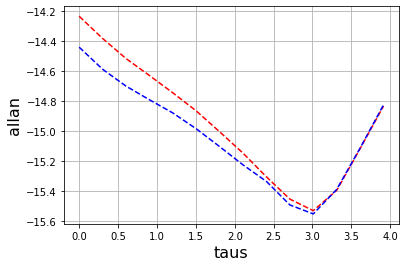

In [46]:
# https://pydatascience.org/2017/11/24/plot-multiple-lines-in-one-chart-with-different-style-python-matplotlib/
plot(np.log10(taus_origin), np.log10(adevs_origin), 'r--', np.log10(taus_refined), np.log10(adevs_refined), 'b--')
xlabel('taus', fontsize=16)
ylabel('allan', fontsize=16)
grid(True)
show()

### 6. Performance evaluation

Evaluate the stability and prediction accuracy

In [19]:
clock_idx = jump_clock_idx[0]
print('The clock to evaluate performance is %s' % clock_idx)

The clock to evaluate performance is 0


In [20]:
real_clock_arr = clock_rp_minus_ensemble[rp_window_size:rp_window_size+n_pred,clock_idx]

In [21]:
clock_pred_results = clock_rp_extrapolation_list[0]
clock_pred_arr = np.array([clock_pred_results[i] for i in range(n_pred)])

In [22]:
jump_idx = jump_idx_list[:,clock_idx] < n_pred
print('Number of jump points are: %s' % rand_keep_size)
print('For inx < %s, there are %s jump points' % (n_pred, np.sum(jump_idx)))

Number of jump points are: 4000
For inx < 40000, there are 2185 jump points


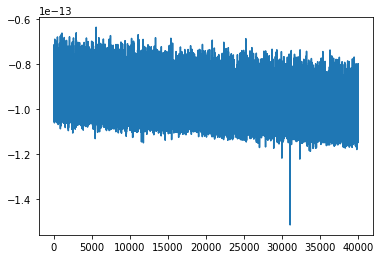

In [23]:
plt.plot(real_clock_arr)

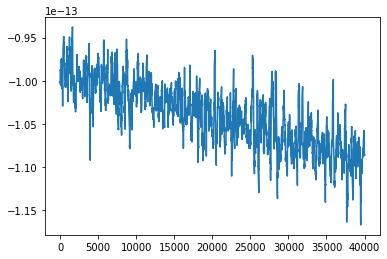

In [24]:
plt.plot(clock_pred_arr)

In [25]:
print("Number data alert: %s" % len(alert_idxs))
print(alert_idxs)

Number data alert: 1378
[8, 13, 23, 40, 125, 135, 166, 263, 273, 274, 300, 304, 358, 360, 387, 415, 480, 568, 594, 610, 642, 678, 751, 780, 849, 860, 863, 939, 962, 989, 991, 1004, 1073, 1093, 1139, 1167, 1190, 1212, 1272, 1376, 1409, 1436, 1463, 1564, 1649, 1662, 1673, 1675, 1694, 1704, 1713, 1764, 1776, 1783, 1796, 1819, 1826, 1854, 1867, 1881, 1904, 1925, 1945, 1986, 1992, 1999, 2017, 2031, 2060, 2062, 2066, 2079, 2188, 2199, 2221, 2244, 2304, 2355, 2435, 2437, 2461, 2514, 2519, 2579, 2588, 2608, 2661, 2722, 2765, 2768, 2811, 2852, 2877, 2894, 2920, 2948, 2953, 2964, 2995, 3002, 3004, 3045, 3116, 3122, 3186, 3206, 3243, 3262, 3266, 3299, 3329, 3389, 3417, 3495, 3567, 3570, 3597, 3598, 3627, 3648, 3703, 3721, 3750, 3764, 3850, 3874, 3925, 3932, 3942, 3986, 4002, 4019, 4035, 4043, 4061, 4068, 4100, 4104, 4197, 4219, 4245, 4253, 4254, 4277, 4289, 4299, 4306, 4324, 4348, 4501, 4505, 4522, 4550, 4570, 4573, 4598, 4612, 4622, 4658, 4659, 4779, 4784, 4816, 4825, 4841, 4978, 5075, 5102, 511

In [26]:
# beyond_3_sigma = np.abs(real_clock_arr - clock_pred_arr) >= 3 * sigmas[clock_idx]
# print("Number data beyond 3 sigma: %s" % np.sum(beyond_3_sigma))
# print(np.where(beyond_3_sigma)[0])

In [27]:
jump_idx_before_n_pred = jump_idx_list[(jump_idx_list[:,clock_idx] < n_pred), clock_idx]

print("Number data has jump: %s" % jump_idx_before_n_pred.shape[0])
print(np.sort(jump_idx_before_n_pred))

Number data has jump: 2185
[    0     3     8 ... 39955 39980 39990]


In [28]:
def cal_precision_recall(true_list, pred_list):
    count = 0
    for item in true_list:
        if item in pred_list:
            count += 1
    return count / len(true_list), count / len(pred_list)

In [29]:
precision, recall = cal_precision_recall(list(jump_idx_before_n_pred), alert_idxs)
print("Precision: %s" % precision)
print("Recall: %s" % recall)

Precision: 0.6302059496567506
Recall: 0.9992743105950653
